In [1]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import activations
from keras.applications.resnet50 import ResNet50
from keras.layers import Input
from keras.models import Model, load_model
from keras.layers.core import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras import backend as K

from vis.visualization import visualize_saliency
from vis.utils import utils

from sklearn.metrics import accuracy_score, confusion_matrix


Using TensorFlow backend.


# Data

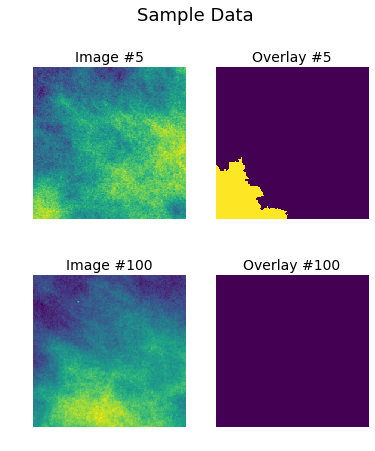

In [5]:
img_index = [5,100]
fig,axes = plt.subplots(len(img_index),2,figsize=(6,7))
fig.suptitle('Sample Data',fontsize=18)
for i,index in enumerate(img_index):
    axes[i,0].imshow(np.squeeze(train_X[index]))
    axes[i,0].set_title('Image #'+str(index),fontsize=14)
    axes[i,1].imshow(np.squeeze(train_y[index]))
    axes[i,1].set_title('Overlay #'+str(index),fontsize=14);
for ax in axes.ravel():
    ax.axis('off')

# Metrics

In order to achieve both accuracy and explanability in our cancer diagnosis result, we consider the following three metrics as criteria to our models:

1. For accuracy, we introduce **Diagnosis Accuracy**. When there is at least one pixel marked abnormal in the image, we classify the entire image as abnormal. We compare the binary classification results of the doctors and our own models.

<center>
$\text{Diagnosis Accuracy} = \frac{\text{Number of images classified correctly}}{\text{Total number of images}}$
</center>


2. To measure explanability, we use **Pixel Accuracy**. Since we explain our diagnosis result by providing overlay predictions, it is crucial that these overlay maps points out correct regions of the abnormal cells. We compare our predictions with doctor's annotations to calculate the accuracy in terms of pixels.

<center>
$\text{Pixel Accuracy} = \frac{\text{Number of pixels classified correctly}}{\text{Total number of pixels}}$
</center>


3. Because our project goal is to find the abnormal cells, we also introduce **Intersection over Union** to focus on these abnormal regions. This metric measures how much our result overlaps with the true annotated regions. 

<center>
$\text{Intersection over Union} = \frac{\text{Intersection of identified problem pixels}}{\text{Union of identified problem pixels}}$
</center>

All three metrics above have a range of 0 to 1, with 1 being ideal.

In [24]:
# numpy
def pixel_acc_m(y_true,y_pred):
    y_true = np.squeeze(y_true,axis=-1)
    y_pred = np.round(np.squeeze(y_pred,axis=-1))
    compare = y_true == y_pred
    return np.sum(compare)/np.product(compare.shape)

def diagnosis_acc_m(y_true,y_pred):
    y_true = y_true.reshape((-1,256*256))
    y_pred = np.round(y_pred).reshape((-1,256*256))
    
    max_true = np.max(y_true,axis=1)
    max_pred = np.max(y_pred,axis=1)
    
    compare = max_true == max_pred
    return np.sum(compare)/np.product(compare.shape)

def IoU_m(y_true,y_pred):
    y_pred = np.round(y_pred)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection/union


# Models

## Baseline Model

We predict all pixels to be either 1 or 0 as our baseline model.

In [22]:
y_one = np.ones((len(test_X),256,256,1))
y_zero = np.zeros((len(test_X),256,256,1))

pixel_acc_1 = pixel_acc_m(sample_y,y_one)
pixel_acc_0 = pixel_acc_m(sample_y,y_zero)
diagnosis_acc_1 = diagnosis_acc_m(sample_y,y_one)
diagnosis_acc_0 = diagnosis_acc_m(sample_y,y_zero)
IoU_1 = IoU_m(sample_y,y_one)
IoU_0 = IoU_m(sample_y,y_zero)

performance_1 = [pixel_acc_1,diagnosis_acc_1,IoU_1]
performance_0 = [pixel_acc_0,diagnosis_acc_0,IoU_0]

df_performance = pd.DataFrame(np.array([performance_1,performance_0]))
df_performance.index = ['All ones','All zeros']
df_performance.columns = ['pixel acc (test set)','diagnosis acc (test set)','IoU']
display(df_performance)

,pixel acc,diagnosis acc,IoU
All ones,0.077732,0.300173,0.077732
All zeros,0.922268,0.699827,0.000000


Although the image classes are rather balanced (normal:abnormal = 0.7:0.3) as a result of special attention paid during the data preprocessing stage, the pixel classes are very imbalanced (normal:abnormal = 0.92:0.08).

## ResNet Model

Part of our project is to use Resnet as the prediction model to make diagnosis on these cancer images. We first read in the data and pre-process the data to best suit Resnet. Because Resnet is a classification model, we train it with the image data and the label for each image. We also read in test data at this step.

In [ ]:
# read in X_train and y_train data
file_path_train = pd.read_csv('mass_training_path.csv')

X_train = []
y_train = []
LEN = 0

for index, row in file_path_train.iterrows():
    try:
        arr = np.load(row['train_X'])
        X_train.append(arr)
        y_train.append(row['label'])
        LEN += 1
    except ValueError:
        print('Skip {} row...'.format(index))
    
SIZE = 256
DIM = 1
    
X_train = np.array(X_train)
y_train = np.array(y_train)

# reshape so that Resnet can use
X_train = X_train.reshape(LEN, SIZE, SIZE, DIM)

# normalize
X_train = X_train / 65535

# to categorical
y_train = keras.utils.to_categorical(y_train, None)

print(X_train.shape)
print(y_train.shape)


input_shape = X_train.shape[1:]

In [5]:
file_path_test = pd.read_csv('mass_testing_path.csv')

# read in X_test, y_test, and also y_test_pixel
# We need pixel-by-pixel information from y_test for later metrics calculation
X_test = []
y_test = []
y_test_pixel = []
LEN = 0

for index, row in file_path_test.iterrows():
    try:
        arr = np.load(row['test_X'])
        X_test.append(arr)
        y_test.append(row['label'])
        y_test_pixel.append(np.load(row['test_y']))
        LEN += 1
    except ValueError:
        print('Skip {} row...'.format(index))

SIZE = 256
DIM = 1
    
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(LEN, SIZE, SIZE, DIM)

#normalize
X_test = X_test / 65535
y_test_pixel = np.array(y_test_pixel) / 255


#to categorical
y_test = keras.utils.to_categorical(y_test, None)

print(X_test.shape)
print(y_test.shape)


(5835, 256, 256, 1)
(5835, 2)


Then we build our model using the built-in Resnet50 structure from Keras. We add a Dense layer to Resnet50 at the end. With two outputs from the softmax function, the entire model is able to produce probabilities for each image being normal and abnormal.

In [ ]:
def RESNET_50(classes_number, input_shape, optim_name='Adam', learning_rate=0.001):
    

    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(include_top=True, weights=None, input_tensor = input_tensor)
    x = base_model.layers[-2].output
    del base_model.layers[-1:]
    x = Dense(classes_number, activation='softmax', name='predictions')(x)
    model = Model(input=base_model.input, output=x)

    if optim_name == 'Adam':
        model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

In [9]:
model_0 = RESNET_50(2, input_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  # This is added back by InteractiveShellApp.init_path()


We ran 200 epochs previously to determine where should the training stop at. After making the following graph, we decide that 40 epochs are enough. We therefore train our Resnet model using 40 epochs.
<img src="epochs.png">

In [12]:
history_0 = model_0.fit(x=X_train, 
            y=y_train, 
            batch_size=32, 
            epochs=40, 
            verbose=1, 
            validation_split=0.1,
            shuffle = True)
model_0.save('model_0.h5') 

Train on 17731 samples, validate on 1971 samples
Epoch 1/40
17731/17731 [==============================] - 602s 34ms/step - loss: 0.6472 - acc: 0.6817 - val_loss: 0.5386 - val_acc: 0.7407
Epoch 2/40
17731/17731 [==============================] - 605s 34ms/step - loss: 0.5783 - acc: 0.6896 - val_loss: 0.5417 - val_acc: 0.7549
Epoch 3/40
17731/17731 [==============================] - 605s 34ms/step - loss: 0.5542 - acc: 0.7144 - val_loss: 0.5403 - val_acc: 0.7088
Epoch 4/40
17731/17731 [==============================] - 606s 34ms/step - loss: 0.5487 - acc: 0.7221 - val_loss: 0.5173 - val_acc: 0.7453
Epoch 5/40
17731/17731 [==============================] - 602s 34ms/step - loss: 0.5480 - acc: 0.7240 - val_loss: 0.5137 - val_acc: 0.7615
Epoch 6/40
17731/17731 [==============================] - 601s 34ms/step - loss: 0.5493 - acc: 0.7231 - val_loss: 0.6092 - val_acc: 0.7585
Epoch 7/40
17731/17731 [==============================] - 606s 34ms/step - loss: 0.5457 - acc: 0.7282 - val_loss: 0.5

In [57]:
model_0 = load_model('model_0.h5')
model_0.evaluate(X_test, y_test)

5835/5835 [==============================] - 75s 13ms/step


[0.4850628539140958, 0.76898029138619]

After training 40 epochs, the model reaches 76.9% test accuracy. We would like to compare the performance of our different models using not only the diagnosis accuracy, but also pixel-by-pixel accuracy and Intersection over Union (IoU). The last two metrics will tell us more about the model's 'explainability'. It's a little bit tricky to calculate these two metrics for Resnet, since Resnet only produces classification results. We will therefore use saliency maps as an indication of what the model 'thinks' of each pixel. 

Since it takes 2 minutes to produce each saliency map from Resnet, we decide to use 400 randomly selected images from `X_test` as a proxy for the entire set. The way we process saliency maps goes as follow. If Resnet predicts the image to be abnormal, we would calculate its saliency map and normalize it so that each pixel in the map is between 0 and 1. After normalization, we round each pixel to be exactly 0 or 1. If Resnet predicts the image to be normal, we assume that the resulting map is zero across all pixels in that image. Then, we calculate pixel-by-pixel accuracy and IoU by comparing the resulting map with the true pixel classification stored in `y_test_pixel`.

Note: Unet and Resunet will both use the same 400 images to calculate their pixel-by-pixel accuracy and IoU. This ensures that our comparison among models is fair.

In [ ]:
# choose 400 samples from X_test and save their indices to a file
# this ensures every model uses the same 400 samples

# a = np.random.randint(0, len(X_test), 400)
# np.savetxt("idx_test_comparison.csv", a, '%s', delimiter=",")

In [ ]:
# take the 400 samples
a = genfromtxt("idx_test_comparison.csv", delimiter=',')
a = a.astype('int')
X_test_400 = X_test[a]
y_test_400 = y_test_pixel[a]

# let Resnet predict on these 400 samples
y_pred_400 = model_0.predict(X_test_400) 

# Prepare the abnormal samples predicted by Resnet
# For saliency map processing
X_test_ab_400 = X_test_400[y_pred_400[:,1] > y_pred_400[:,0]]
y_test_ab_400 = y_test_400[y_pred_400[:,1] > y_pred_400[:,0]]

# prepare the normal samples 
X_test_nm_400 = X_test_400[y_pred_400[:,1] <= y_pred_400[:,0]]
y_test_nm_400 = y_test_400[y_pred_400[:,1] <= y_pred_400[:,0]]

In [197]:
def pixel_by_pixel_percentage(X_ab, y_ab, model):
    # input:
    # X_ab is a list of abnormal images 
    # y_ab is a list of the abnormal images' true pixel-by-pixel classifications
    # model is the trained Resnet model
    # output:
    # accuracy is a list of pixel-by-pixel accuracy scores
    # saliency_maps is a list of saliency maps produced by the model on the abnormal images
    
    accuracy = []
    saliency_maps = []
    for i in range(len(X_ab)):
        # calculate saliency map
        grads = visualize_saliency(model, layer_idx, filter_indices=1, seed_input=X_ab[i])
        
        #normalize saliency map
        grads = grads/np.max(grads)
        
        #round saliency map
        grads[grads > 0.5] = 1
        grads[grads <= 0.5] = 0
        
        #produce outputs
        saliency_maps.append(grads)
        accuracy.append(accuracy_score(y_ab[i].flatten(), grads.flatten()))
        print("{}/{}".format(i + 1, len(X_ab)))

    return accuracy, saliency_maps

# calculate pixel-by-pixel acc using predicted abnormal data from the 400 samples
accuracy_ab, saliency_maps = pixel_by_pixel_percentage(X_test_ab_400, y_test_ab_400, model_0)
accuracy_ab = np.array(accuracy_ab)
saliency_maps = np.array(saliency_maps)

# save outputs
# np.save("pbp_acc_ab", accuracy)
# np.save("saliency_maps_ab", saliency_maps)

1/84
2/84
3/84
4/84
5/84
6/84
7/84
8/84
9/84
10/84
11/84
12/84
13/84
14/84
15/84
16/84
17/84
18/84
19/84
20/84
21/84
22/84
23/84
24/84
25/84
26/84
27/84
28/84
29/84
30/84
31/84
32/84
33/84
34/84
35/84
36/84
37/84
38/84
39/84
40/84
41/84
42/84
43/84
44/84
45/84
46/84
47/84
48/84
49/84
50/84
51/84
52/84
53/84
54/84
55/84
56/84
57/84
58/84
59/84
60/84
61/84
62/84
63/84
64/84
65/84
66/84
67/84
68/84
69/84
70/84
71/84
72/84
73/84
74/84
75/84
76/84
77/84
78/84
79/84
80/84
81/84
82/84
83/84
84/84


In [40]:
# calculate pixel-by-pixel acc using predicted normal data from the 400 samples
accuracy_nm = []
for i in range(len(y_test_nm_400)):
    acc = accuracy_score(np.zeros(shape = (256, 256)), y_test_nm_400[i])
    accuracy_nm.append(acc)
accuracy_nm = np.array(accuracy_nm)

# combine both predicted normal data and predicted abnormal data's pixel-by-pixel acc
accuracy_ab = np.load("pbp_acc_ab.npy")
acc = (np.sum(accuracy_nm) + np.sum(accuracy_ab)) / 400 # calculate saliency maps only on the 400 samples

print('The pixel-by-pixel accuracy is {}.'.format(acc))

The pixel-by-pixel accuracy is 0.8813468551635742.


In [44]:
def intersection_over_union(Y_true, Y_pred, additional = 0):
    return ((Y_true==1) & (Y_pred==1)).sum() / (((Y_true==1) | (Y_pred==1)).sum() + additional)

saliency_maps_ab = np.load("saliency_maps_ab.npy")
iou = intersection_over_union(y_test_ab_400, saliency_maps_ab, np.sum(y_test_nm_400 == 1))
print('The IoU is {}.'.format(iou))

The IoU is 0.0007638233884615324.


We obtain 88.13% pixel-by-pixel accuracy and 0.00076 IoU. We also obtain 76.90% diagnosis accuracy. We will compare these results with other models. The last step here is to calculate the confusion matrix. We see that there is 15.88 percent of sample which are abnormal but falsely predicted as normal. This is the least what people want to happen in the medical world, but fortunately we have the doctors to oversee these results and hopefully they can detect the cancer areas where the computer fails to do.  

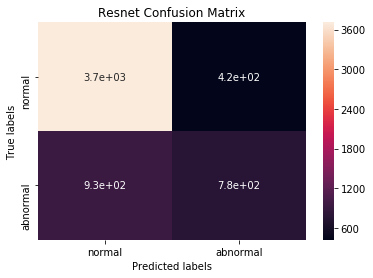

In [56]:
# Have the model's prediction on the whole test set
y_test_pred = model_0.predict(X_test)

# calculate confusion matrix
matrix = confusion_matrix(y_test.argmax(axis=1), y_test_pred.argmax(axis=1))

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Resnet Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);

## U-Net

ResNet has been quite accurate in diagnosing the images and improve explanability by providing saliency maps to point out the area of attention. However, what if we would like to segment the graph directly? U-Net has proved successful in this kind of tasks. It takes in images and outputs images of the same size, classifying each pixel into a certain number of classes, as it uses sigmoid or softmax as the activation of the last layer in the network. It is called U-Net because it has a U-shape symmetric sturcture. In the first half, the network downsamples the feature map dimension with MaxPooling layers, and in the second half, the network upsamples the feature map back to its original dimension with UpSampling layers. Most importantly, it copies over feature maps from the first half and concatenates to the ones in the second half, so that context information gets preserved and used in the final localization. 

### Identical reproduction as in the original paper

In the first section, we borrow the exact structure from the original paper. That is to say, we have the same number and arrangement of layers. Since our image size is smaller, we reduce the number of filters in each layer. Moreover, since our dataset is very imbalanced in terms of the normal/abnormal classes of each pixel, we define our own weighted binary crossentropy loss function to train against, and we adjust the weight to obtain optimal result.

We defined original weights as:

<center>
$\text{normal_weight} = \frac{\text{Total number of pixels}}{\text{Number of normal pixels}}$
</center>

<center>
$\text{abnormal_weight} = \frac{\text{Total number of pixels}}{\text{Number of abnormal pixels}}$
</center>

We experiment with the following combination of weights, to be combined with the typical binary crossentropy loss function:

1. normal class weight = normal_weight; abnormal class weight = abnormal_weight
2. normal class weight = normal_weight; abnormal class weight = abnormal_weight/1.5
3. normal class weight = normal_weight; abnormal class weight = abnormal_weight/2
4. normal class weight = normal_weight; abnormal class weight = abnormal_weight/3

In [23]:
num_one = np.sum(train_y)
num_zero = np.product(train_y.shape)
one_weight = (num_one + num_zero)/num_one
zero_weight = (num_one + num_zero)/num_zero

# keras backend
def weighted_crossentropy(y_true, y_pred):
    entropy = K.binary_crossentropy(y_true, y_pred)
    weight_map = y_true * one_weight + (1. - y_true) * zero_weight    
    weighted_entropy = weight_map * entropy
    return K.mean(weighted_entropy)

def adjweighted_crossentropy(y_true, y_pred):
    entropy = K.binary_crossentropy(y_true, y_pred)
    weight_map = y_true * one_weight/2 + (1. - y_true) * zero_weight    
    weighted_entropy = weight_map * entropy
    return K.mean(weighted_entropy)

def diagnosis_acc(y_true, y_pred):
    true = K.squeeze(y_true,axis=-1)
    pred = K.squeeze(y_pred,axis=-1)
    true = K.max(true,axis=[1,2])
    pred = K.max(pred,axis=[1,2])
    return keras.metrics.binary_accuracy(true, pred)

def IoU(y_true, y_pred): # Region Intersection over Union
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection/union


In [49]:
def unet(k=64,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(k*1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(k*1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(k*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(k*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(k*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(k*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(k*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(k*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(k*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(k*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(k*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(k*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(k*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(k*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(k*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(k*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(k*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(k*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(k*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(k*1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(k*1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(k*1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    return model

In [32]:
unet_orig = unet(64)
unet_orig.compile(optimizer = Adam(lr = 1e-4), 
                  loss = weighted_crossentropy, 
                  metrics = ['acc',diagnosis_acc,IoU])
unet_orig.summary()

early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, verbose=0, mode='min')
unet_orig_history = unet_orig.fit(train_X, train_y, validation_split=0.2,
                                  batch_size=16, epochs=5, verbose=1,
                                  callbacks=[early_stopping])

unet_orig.save('unet_orig.h5')
    

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 256, 256, 64) 640         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_121[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_122[0][0]                 
__________________________________________________________________________________________________
conv2d_123

Train on 15761 samples, validate on 3941 samples
Epoch 1/5
15761/15761 [==============================] - 2098s 133ms/step - loss: 1.4579 - acc: 0.0854 - diagnosis_acc: 0.3091 - IoU: 0.0797 - val_loss: 1.3541 - val_acc: 0.0684 - val_diagnosis_acc: 0.2745 - val_IoU: 0.0684
Epoch 2/5
15761/15761 [==============================] - 2090s 133ms/step - loss: 1.4555 - acc: 0.0801 - diagnosis_acc: 0.3066 - IoU: 0.0801 - val_loss: 1.3545 - val_acc: 0.0684 - val_diagnosis_acc: 0.2745 - val_IoU: 0.0684
Epoch 3/5
15761/15761 [==============================] - 2091s 133ms/step - loss: 1.4549 - acc: 0.0801 - diagnosis_acc: 0.3066 - IoU: 0.0801 - val_loss: 1.3550 - val_acc: 0.0684 - val_diagnosis_acc: 0.2745 - val_IoU: 0.0684
Epoch 4/5
15761/15761 [==============================] - 2091s 133ms/step - loss: 1.4545 - acc: 0.0801 - diagnosis_acc: 0.3066 - IoU: 0.0801 - val_loss: 1.3555 - val_acc: 0.0684 - val_diagnosis_acc: 0.2745 - val_IoU: 0.0684
Epoch 5/5
15761/15761 [==============================] 

In [37]:
unet_orig = unet(32)
unet_orig.compile(optimizer = Adam(lr = 1e-4), 
                  loss = weighted_crossentropy, 
                  metrics = ['acc',diagnosis_acc,IoU])
unet_orig.summary()

early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, verbose=0, mode='min')
unet_orig_history = unet_orig.fit(train_X, train_y, validation_split=0.2,
                                  batch_size=16, epochs=20, verbose=1,
                                  callbacks=[early_stopping])

unet_orig.save('unet_orig_32.h5')

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_241 (Conv2D)             (None, 256, 256, 32) 320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_242 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_241[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_242[0][0]                 
__________________________________________________________________________________________________
conv2d_243

Train on 15761 samples, validate on 3941 samples
Epoch 1/20
15761/15761 [==============================] - 832s 53ms/step - loss: 1.4001 - acc: 0.3184 - diagnosis_acc: 0.3202 - IoU: 0.0887 - val_loss: 1.2342 - val_acc: 0.2890 - val_diagnosis_acc: 0.3258 - val_IoU: 0.0859
Epoch 2/20
15761/15761 [==============================] - 832s 53ms/step - loss: 1.2601 - acc: 0.4759 - diagnosis_acc: 0.3481 - IoU: 0.1251 - val_loss: 1.1881 - val_acc: 0.8294 - val_diagnosis_acc: 0.4047 - val_IoU: 0.1305
Epoch 3/20
15761/15761 [==============================] - 838s 53ms/step - loss: 1.2141 - acc: 0.6234 - diagnosis_acc: 0.3995 - IoU: 0.1496 - val_loss: 1.1676 - val_acc: 0.4990 - val_diagnosis_acc: 0.3415 - val_IoU: 0.1114
Epoch 4/20
15761/15761 [==============================] - 829s 53ms/step - loss: 1.1530 - acc: 0.6619 - diagnosis_acc: 0.4167 - IoU: 0.1673 - val_loss: 0.9792 - val_acc: 0.7595 - val_diagnosis_acc: 0.4435 - val_IoU: 0.1729
Epoch 5/20
15761/15761 [==============================] - 8

In [50]:
def adjweighted_crossentropy(y_true, y_pred):
    entropy = K.binary_crossentropy(y_true, y_pred)
    weight_map = y_true * one_weight/1.5 + (1. - y_true) * zero_weight    
    weighted_entropy = weight_map * entropy
    return K.mean(weighted_entropy)

unet_66weight = unet(32)
unet_66weight.compile(optimizer = Adam(lr = 1e-4), 
                        loss = adjweighted_crossentropy, 
                        metrics = ['acc',diagnosis_acc,IoU])
unet_66weight.summary()

early_stopping = EarlyStopping(monitor='loss', min_delta=0.005, patience=3, verbose=0, mode='min')
unet_66weight_history = unet_66weight.fit(train_X, train_y, validation_split=0.2,
                                          batch_size=32, epochs=30, verbose=1,
                                          callbacks=[early_stopping])

unet_66weight.save('unet_66weight.h5')

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

Train on 15761 samples, validate on 3941 samples
Epoch 1/30
15761/15761 [==============================] - 856s 54ms/step - loss: 1.1363 - acc: 0.6768 - diagnosis_acc: 0.3349 - IoU: 0.0615 - val_loss: 1.0265 - val_acc: 0.4815 - val_diagnosis_acc: 0.2745 - val_IoU: 0.1075
Epoch 2/30
15761/15761 [==============================] - 841s 53ms/step - loss: 1.0946 - acc: 0.5683 - diagnosis_acc: 0.3554 - IoU: 0.1281 - val_loss: 0.9738 - val_acc: 0.8481 - val_diagnosis_acc: 0.4349 - val_IoU: 0.1313
Epoch 3/30
15761/15761 [==============================] - 839s 53ms/step - loss: 1.0247 - acc: 0.7067 - diagnosis_acc: 0.4899 - IoU: 0.1537 - val_loss: 0.9017 - val_acc: 0.7683 - val_diagnosis_acc: 0.5123 - val_IoU: 0.1313
Epoch 4/30
15761/15761 [==============================] - 839s 53ms/step - loss: 0.9784 - acc: 0.7242 - diagnosis_acc: 0.5260 - IoU: 0.1679 - val_loss: 0.9126 - val_acc: 0.7420 - val_diagnosis_acc: 0.5625 - val_IoU: 0.1309
Epoch 5/30
15761/15761 [==============================] - 8

In [51]:
def adjweighted_crossentropy(y_true, y_pred):
    entropy = K.binary_crossentropy(y_true, y_pred)
    weight_map = y_true * one_weight/2 + (1. - y_true) * zero_weight    
    weighted_entropy = weight_map * entropy
    return K.mean(weighted_entropy)

unet_50weight = unet(32)
unet_50weight.compile(optimizer = Adam(lr = 1e-4), 
                        loss = adjweighted_crossentropy, 
                        metrics = ['acc',diagnosis_acc,IoU])
unet_50weight.summary()

early_stopping = EarlyStopping(monitor='loss', min_delta=0.005, patience=3, verbose=0, mode='min')
unet_50weight_history = unet_50weight.fit(train_X, train_y, validation_split=0.2,
                                          batch_size=32, epochs=30, verbose=1,
                                          callbacks=[early_stopping])

unet_50weight.save('unet_50weight.h5')

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_27 

Train on 15761 samples, validate on 3941 samples
Epoch 1/30
15761/15761 [==============================] - 836s 53ms/step - loss: 1.0287 - acc: 0.8395 - diagnosis_acc: 0.3941 - IoU: 0.0175 - val_loss: 0.9614 - val_acc: 0.9316 - val_diagnosis_acc: 0.7249 - val_IoU: nan
Epoch 2/30
15761/15761 [==============================] - 828s 53ms/step - loss: 1.0067 - acc: 0.9199 - diagnosis_acc: 0.6600 - IoU: 1.2155e-04 - val_loss: 0.9364 - val_acc: 0.9316 - val_diagnosis_acc: 0.7222 - val_IoU: nan
Epoch 3/30
15761/15761 [==============================] - 829s 53ms/step - loss: 0.9689 - acc: 0.9199 - diagnosis_acc: 0.6897 - IoU: 4.5158e-07 - val_loss: 0.8545 - val_acc: 0.9316 - val_diagnosis_acc: 0.7229 - val_IoU: nan
Epoch 4/30
15761/15761 [==============================] - 842s 53ms/step - loss: 0.8894 - acc: 0.8325 - diagnosis_acc: 0.6336 - IoU: 0.0713 - val_loss: 0.7651 - val_acc: 0.8346 - val_diagnosis_acc: 0.6488 - val_IoU: 0.1335
Epoch 5/30
15761/15761 [==============================] - 84

In [55]:
def adjweighted_crossentropy(y_true, y_pred):
    entropy = K.binary_crossentropy(y_true, y_pred)
    weight_map = y_true * one_weight/3 + (1. - y_true) * zero_weight    
    weighted_entropy = weight_map * entropy
    return K.mean(weighted_entropy)

unet_33weight = unet(32)
unet_33weight.compile(optimizer = Adam(lr = 1e-4), 
                        loss = adjweighted_crossentropy, 
                        metrics = ['acc',diagnosis_acc,IoU])
unet_33weight.summary()

early_stopping = EarlyStopping(monitor='loss', min_delta=0.005, patience=3, verbose=0, mode='min')
unet_33weight_history = unet_33weight.fit(train_X, train_y, validation_split=0.2,
                                          batch_size=32, epochs=5, verbose=1,
                                          callbacks=[early_stopping])

unet_33weight.save('unet_33weight.h5')

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 256, 256, 32) 320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_97[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_98[0][0]                  
__________________________________________________________________________________________________
conv2d_99 

Train on 15761 samples, validate on 3941 samples
Epoch 1/5
15761/15761 [==============================] - 844s 54ms/step - loss: 0.8320 - acc: 0.9199 - diagnosis_acc: 0.6862 - IoU: 2.1420e-05 - val_loss: 0.7432 - val_acc: 0.9316 - val_diagnosis_acc: 0.7255 - val_IoU: nan
Epoch 2/5
15761/15761 [==============================] - 846s 54ms/step - loss: 0.6949 - acc: 0.9199 - diagnosis_acc: 0.6934 - IoU: 0.0000e+00 - val_loss: 0.6556 - val_acc: 0.9316 - val_diagnosis_acc: 0.7255 - val_IoU: nan
Epoch 3/5
15761/15761 [==============================] - 843s 53ms/step - loss: 0.6721 - acc: 0.9199 - diagnosis_acc: 0.6934 - IoU: 0.0000e+00 - val_loss: 0.5968 - val_acc: 0.9316 - val_diagnosis_acc: 0.7255 - val_IoU: nan
Epoch 4/5
15761/15761 [==============================] - 839s 53ms/step - loss: 0.6691 - acc: 0.9199 - diagnosis_acc: 0.6934 - IoU: 0.0000e+00 - val_loss: 0.6175 - val_acc: 0.9316 - val_diagnosis_acc: 0.7255 - val_IoU: nan
Epoch 5/5
15761/15761 [==============================] - 83

### Deeper U-Net

Next, we add two additional blocks to construct a deeper UNet.

In [56]:
## Adjusted U-Net

deeper, fewer filter in each layer def unet_deeper(k=64,input_size = (256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(k*1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(k*1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(k*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(k*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(k*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(k*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv3_2 = Conv2D(k*6, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv3_2 = Conv2D(k*6, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_2)
    drop3_2 = Dropout(0.5)(conv3_2)
    pool3_2 = MaxPooling2D(pool_size=(2, 2))(drop3_2)
    
    conv4 = Conv2D(k*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3_2)
    conv4 = Conv2D(k*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(k*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(k*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(k*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(k*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(k*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    up6_2 = Conv2D(k*6, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge6_2 = concatenate([drop3_2,up6_2], axis = 3)
    conv6_2 = Conv2D(k*6, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6_2)
    conv6_2 = Conv2D(k*6, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6_2)

    up7 = Conv2D(k*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6_2))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(k*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(k*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(k*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(k*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(k*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(k*1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(k*1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(k*1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    return model

In [81]:
def adjweighted_crossentropy(y_true, y_pred):
    entropy = K.binary_crossentropy(y_true, y_pred)
    weight_map = y_true * one_weight/2 + (1. - y_true) * zero_weight    
    weighted_entropy = weight_map * entropy
    return K.mean(weighted_entropy)

unet_deeper_50weight = unet_deeper(32)
unet_deeper_50weight.compile(optimizer = Adam(lr = 1e-4), 
                        loss = adjweighted_crossentropy, 
                        metrics = ['acc',diagnosis_acc,IoU])
unet_deeper_50weight.summary()

early_stopping = EarlyStopping(monitor='loss', min_delta=0.005, patience=3, verbose=0, mode='min')
unet_deeper_50weight_history = unet_deeper_50weight.fit(train_X, train_y, validation_split=0.2,
                                          batch_size=32, epochs=30, verbose=1,
                                          callbacks=[early_stopping])

unet_deeper_50weight.save('unet_deeper_50weight.h5')

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 256, 256, 32) 320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_209 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_208[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_209[0][0]                 
__________________________________________________________________________________________________
conv2d_210

Train on 15761 samples, validate on 3941 samples
Epoch 1/30
15761/15761 [==============================] - 824s 52ms/step - loss: 1.0675 - acc: 0.9111 - diagnosis_acc: 0.5538 - IoU: 0.0014 - val_loss: 1.0143 - val_acc: 0.9316 - val_diagnosis_acc: 0.7237 - val_IoU: nan
Epoch 2/30
15761/15761 [==============================] - 813s 52ms/step - loss: 1.0595 - acc: 0.9199 - diagnosis_acc: 0.6928 - IoU: 0.0000e+00 - val_loss: 1.0049 - val_acc: 0.9316 - val_diagnosis_acc: 0.7252 - val_IoU: nan
Epoch 3/30
15761/15761 [==============================] - 812s 52ms/step - loss: 1.0524 - acc: 0.9199 - diagnosis_acc: 0.6934 - IoU: 0.0000e+00 - val_loss: 0.9965 - val_acc: 0.9316 - val_diagnosis_acc: 0.7252 - val_IoU: nan
Epoch 4/30
15761/15761 [==============================] - 812s 52ms/step - loss: 1.0462 - acc: 0.9199 - diagnosis_acc: 0.6934 - IoU: 0.0000e+00 - val_loss: 0.9889 - val_acc: 0.9316 - val_diagnosis_acc: 0.7252 - val_IoU: nan
Epoch 5/30
15761/15761 [==============================] - 8

### Model Evaluation

We evaluate our six UNet models based on the three metrics on test set. For consistent comparison with the ResNet, we also calculate these metrics on the 400 sample set .

In [82]:
def evaluate_model(model,load_local_model=True):
    if load_local_model:
        if model in ['unet_orig.h5','unet_orig_32.h5']:
            model = load_model(model, custom_objects={'weighted_crossentropy': weighted_crossentropy,
                                                      'diagnosis_acc': diagnosis_acc,
                                                      'IoU': IoU})
        else:
            model = load_model(model, custom_objects={'adjweighted_crossentropy': adjweighted_crossentropy,
                                                      'diagnosis_acc': diagnosis_acc,
                                                      'IoU': IoU})
        
    y_pred_test = model.predict(test_X)
    y_pred_sample = model.predict(sample_X)
    
    #pixel_acc
    r_pixel_acc = pixel_acc_m(test_y,y_pred_test)
    r_pixel_acc_sample = pixel_acc_m(sample_y,y_pred_sample)
    #diagnosis_acc
    r_diagnosis_acc = diagnosis_acc_m(test_y,y_pred_test)
    r_diagnosis_acc_sample = diagnosis_acc_m(sample_y,y_pred_sample)
    #IoU
    r_IoU = IoU_m(test_y,y_pred_test)
    r_IoU_sample = IoU_m(sample_y,y_pred_sample)
    
    return np.array([r_pixel_acc,r_pixel_acc_sample,
                     r_diagnosis_acc,r_diagnosis_acc_sample,
                     r_IoU,r_IoU_sample])

In [95]:
UNet_comparison = []
models = ['unet_orig.h5','unet_orig_32.h5',
          'unet_66weight.h5','unet_50weight.h5','unet_33weight.h5',
          'unet_deeper_50weight.h5']

for model in models:
    UNet_comparison.append(evaluate_model(model,load_local_model=True))

In [100]:
df_UNet_comparison = pd.DataFrame(UNet_comparison)
df_UNet_comparison.columns = ['pixel acc (test set)','pixel acc (sample)',
                              'diagnosis acc (test set)','diagnosis acc (sample)',
                              'IoU (test set)','IoU (sample)']
df_UNet_comparison.index = ['UNet with additional filters',
                            'Baseline UNet',
                            r'UNet with $\frac{2}{3}$ abnormal weight',
                            r'UNet with $\frac{1}{2}$ abnormal weight',
                            r'UNet with $\frac{1}{3}$ abnormal weight',
                            r'UNet with $\frac{1}{2}$ abnormal weight and additional layers']
df_UNet_comparison

,pixel acc (test set),pixel acc (sample),diagnosis acc (test set),diagnosis acc (sample),IoU (test set),IoU (sample)
UNet with additional filters,0.070563,0.072383,0.292031,0.2875,0.070563,0.072383
Baseline UNet,0.858379,0.869158,0.622279,0.5800,0.234401,0.259585
UNet with $\frac{2}{3}$ abnormal weight,0.856579,0.861317,0.592631,0.5400,0.235870,0.247150
UNet with $\frac{1}{2}$ abnormal weight,0.906395,0.911682,0.679863,0.6450,0.267063,0.269452
UNet with $\frac{1}{3}$ abnormal weight,0.929437,0.927617,0.707969,0.7125,0.000000,0.000000
UNet with $\frac{1}{2}$ abnormal weight and additional layers,0.929437,0.927617,0.707969,0.7125,0.000000,0.000000


In the table above, we list the metric results of our UNet models. We find that having additional filters or additional layers does not necessarily improve the model. In fact, it is frequent that the model stucks at predicting all ones or all zeros. This is indicated by the fact that the metric results are the same as those of our baseline models, which predict all normal or all abnormal.

Before we weigh our loss function, because the number of normal pixels strong outweighs the abnormal ones, the model classify all pixels to be normal, no matter what the input is. After we weigh our loss function, nevertheless, the model tends to lean towards predicting all pixels to be abnormal. As we gradually adjust the weight, we found that the model with half abnormal weight performs the best. On the test set, it has a 0.91 pixel accuracy, 0.68 diagnosis accuracy, and 0.27 Intersection over Union. Its confusion matrix is plotted below.

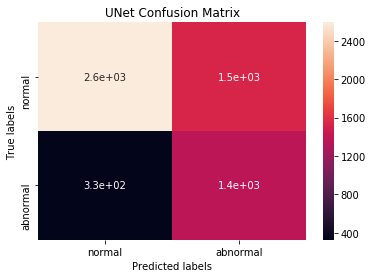

In [54]:
class_test = df_paths_test.iloc[:,4].values

class_test_pred = unet_50weight.predict(test_X)
class_test_pred = np.round(class_test_pred).reshape((-1,256*256))
class_test_pred = np.max(class_test_pred,axis=1)

matrix = confusion_matrix(class_test,class_test_pred)

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('UNet Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);